##Fit a prf model with frequency selectivity and an output nonlinearity.
July.2015 high-resolution CMRR data for the "match_nonmatch" project.

Project notes: https://drive.google.com/open?id=1m1rmotkmtgwY99Q_k71YDorUPq_DkCSJ0LselY13_v4

In [56]:
%pylab inline
import hrf_fitting.src.preprocessing as preproc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import nibabel as nib
import pickle


from PIL import Image
from hrf_fitting.src.features import construct_placement_grid,make_kernel_grid,complex_ripple_filter,compute_grid_corners
from scipy.signal import convolve2d
from os import path
from sklearn import linear_model
from glob import glob
from sklearn.metrics import explained_variance_score,r2_score
from scipy.stats.mstats import zscore
from joblib import Parallel, delayed
from time import time
from scipy.interpolate import griddata

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


###Select data

select a subject and corresponding database

In [2]:
subject = 's1055'
db =  '/media/tnaselar/Data/July_2015_preproc/'+subject+'/PS/aligned_db.csv'

import into pandas dataframe and view it

In [3]:
data_db = pd.io.parsers.read_csv(db,header=0)
data_db.head(5)

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
0,0,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
1,1,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
2,2,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
3,3,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
4,4,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


###Specify runs for training and testing the model

In [4]:
def select_run(row,runType):
    return row['runType'] in [runType]


wedge_runs = list(data_db[data_db.apply(select_run,axis=1,args=('wedge',))].runID)
bar_runs = list(data_db[data_db.apply(select_run,axis=1,args=('bar',))].runID)
art_runs = list(data_db[data_db.apply(select_run,axis=1,args=('art',))].runID)

training_runs = wedge_runs[1:3]+bar_runs[1:3]
selection_runs = wedge_runs[0:1]+bar_runs[0:1]
validation_runs = wedge_runs[5:-1]+bar_runs[5:-1]
# validation_run_ids = data_db[data_db.apply(lambda row: row['runType'] in validation_run_types,axis=1)].runID

In [5]:
data_db.iloc[training_runs] 

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
1,1,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
13,13,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
3,3,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
4,4,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


In [6]:
data_db.iloc[selection_runs]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
0,0,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
2,2,27/07/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


In [7]:
data_db.iloc[validation_runs]

,runID,date,subject,experiment,working_vol,brain_mask,sessionID,runType,design matrix,frame_file,...,vox_x,vox_y,vox_z,run_code_path,run_code_file,design_matrix_path,frameFilePath,picPath,siemensRef,padVol
21,21,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,wedge,none,wedge_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0
22,22,04/08/2015,s1055,match_nonmatch,/media/tnaselar/Data/July_2015_preproc/s1055/P...,/media/tnaselar/Data/July_2015_preproc/s1055/P...,1,bar,none,bar_frame_file.txt,...,0.8,0.8,0.8,/musc.repo/mri/7T.cmrr/July.2015/PS/presentation,run_experiment.py,none,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,/musc.repo/mri/7T.cmrr/July.2015/PS/presentati...,0,0


###Load neural data

In [8]:
training_vols = preproc.load_runs(data_db,training_runs)
selection_vols = preproc.load_runs(data_db,selection_runs)
validation_vols = preproc.load_runs(data_db,validation_runs)

detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
detrending run 2 with window_length: 101
detrending run 3 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400
zscoring 400 thru 600
zscoring 600 thru 800
detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400
detrending run 0 with window_length: 101
detrending run 1 with window_length: 101
zscoring 0 thru 200
zscoring 200 thru 400


In [9]:
validation_vols

Reshape, mask, and remove inf's. Need to add this functionality to "load_runs"

In [10]:
##optional coronal slice selection
first_slice,last_slice = -25,-1

##first the mask. mucked up the database somehow, so reading in the brain mask is a stupid mess
bm = glob('/media'+data_db.iloc[training_runs[0]]['brain_mask'].split('/media')[2]+'/*.gz')
mask_image = nib.load(bm[0]).get_data().astype('bool') ##a numpy boolean

##now some indices for coronal slicing.
zdx = np.zeros(training_vols.shape[0:3]).astype('bool')
zdx[:,:,first_slice:last_slice] = True

##can't use any of the voxels with knackered values
finite_voxels = np.isfinite(training_vols.get_data()).all(axis=3)*np.isfinite(selection_vols.get_data()).all(axis=3)

mask_image = mask_image*zdx*finite_voxels

In [11]:
def apply_mask(vol,raveled_mask):
    vol = vol.get_data().reshape((np.prod(vol.shape[0:3]),vol.shape[3])).T  ##converts to (time, xyz)
    return vol[:,raveled_mask]
    

In [12]:
##test masking
mean_vol = preproc.load_runs(data_db,selection_runs,detrend=False,z_score=False)
mean_vol = apply_mask(mean_vol,mask_image.ravel()).mean(axis=0)
test_view = np.zeros(mask_image.shape).ravel()
test_view[mask_image.ravel()] = mean_vol
test_view = test_view.reshape(mask_image.shape)

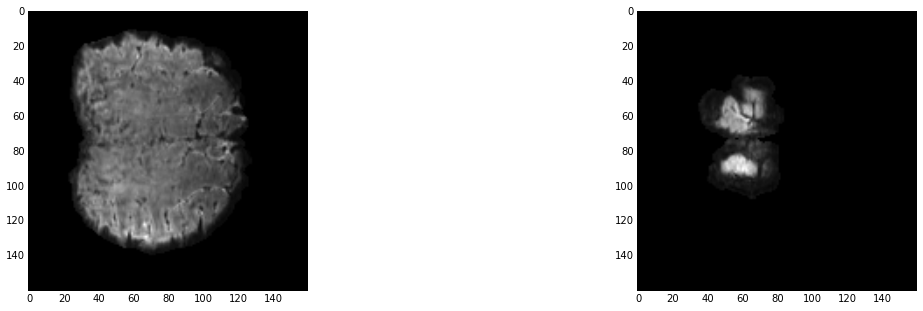

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.imshow(test_view[:,:,first_slice],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(test_view[:,:,last_slice-1],cmap=cm.gray)

In [14]:
training_vols = apply_mask(training_vols,mask_image.ravel()) 

In [15]:
print 'training vol dimensions: %s' %(training_vols.shape,)

training vol dimensions: (800, 165406)


In [16]:
selection_vols = apply_mask(selection_vols,mask_image.ravel()) 

In [17]:
print 'selection vol dimensions: %s' %(selection_vols.shape,)

selection vol dimensions: (400, 165406)


In [18]:
validation_vols = apply_mask(validation_vols,mask_image.ravel())

In [19]:
print 'validation vol dimensions: %s' %(validation_vols.shape,)

validation vol dimensions: (400, 165406)


###Load images
We happen to know that for the 'wedge' and 'bar' runs, the framefiles are identical. So we don't need
to all of them into memory. Instead, we load in one copy, and create a function that will be used to concatenate feature matrices when it's time to train the model.

In [110]:
##some important units
native_stim_size = 768. ##I just know this
working_image_size = 312.
image_downsampling = working_image_size/native_stim_size ##I choose this
pixel_per_deg = 34.751*image_downsampling    ##I just know this  
pixels_per_stimulus = int(native_stim_size*image_downsampling) 
wedge_nvols = data_db.iloc[selection_runs[0]].nvols ##we happen to know what 0 and 1 mean
bar_nvols = data_db.iloc[selection_runs[1]].nvols

print 'pixels per degree: %0.2f' %(pixel_per_deg)
print 'pixels per image: %d' %(pixels_per_stimulus)

pixels per degree: 14.12
pixels per image: 312


In [107]:
##list of stimulus frames, as they were presented
wedge_stim_list = preproc.load_frame_file(data_db.iloc[selection_runs[0]]) 
bar_stim_list = preproc.load_frame_file(data_db.iloc[selection_runs[1]])
pic_path = data_db.iloc[selection_runs[0]].picPath

In [108]:
wedge_imgs = np.array(map(lambda img: np.array(Image.open(img).convert('L').resize((pixels_per_stimulus,)*2)),
                          map(lambda f: path.join(pic_path,f),wedge_stim_list)),
                      ndmin=3)
print 'wedge images taking up %0.3f GB of RAM' %(wedge_imgs.nbytes/1024./1024./1024.)

wedge images taking up 0.408 GB of RAM


In [23]:
bar_imgs = np.array(map(lambda img: np.array(Image.open(img).convert('L').resize((pixels_per_stimulus,)*2)),
                          map(lambda f: path.join(pic_path,f),bar_stim_list)),
                    ndmin=3)
print 'bar images taking up %0.3f GB of RAM' %(bar_imgs.nbytes/1024./1024./1024.)

bar images taking up 0.275 GB of RAM


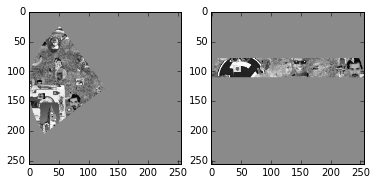

In [24]:
plt.figure
plt.subplot(1,2,1)
plt.imshow(wedge_imgs[400,:,:],cmap=cm.gray)
plt.subplot(1,2,2)
plt.imshow(bar_imgs[400,:,:],cmap=cm.gray)

###Construct features

Specify the set of ripple filters

In [111]:

##preferences
min_cyc_deg = 0.1
max_cyc_deg = 3.
min_kernel_size = .5    ##deg
max_kernel_size = 10.5    ##deg
kernel_spacing = 1. ##deg
num_freq_levels = 4
num_size_levels = 4
boundary_condition = 1

##---frequencies
##cyc/deg
freq_df = pd.DataFrame(np.logspace(np.log10(min_cyc_deg),np.log10(max_cyc_deg),num=num_freq_levels,endpoint=True),
                       columns=['cyc/deg'])
##cyc/pix
freq_df['cyc/pix'] = freq_df['cyc/deg'].apply(lambda x: x/pixel_per_deg)
##cyc/image
freq_df['cyc/image'] = freq_df['cyc/pix'].apply(lambda x: x*pixels_per_stimulus)
##pix/cyc -- check to make sure greater than 6, as per Curtis Baker
freq_df['pix/cyc'] = freq_df['cyc/pix'].apply(lambda x: 1/x)

##---kernel sizes
##deg
size_df = pd.DataFrame(np.linspace(min_kernel_size, max_kernel_size,num=num_size_levels,endpoint=True),
                       columns = ['deg.'])
##pix
size_df['pix'] = size_df['deg.'].apply(lambda x: x*pixel_per_deg)



##---kernel position grid
pix_spacing = kernel_spacing*pixel_per_deg
corners=compute_grid_corners(working_image_size,size_df['pix'].min(),boundary_condition=1)  #not quite on edge of image
pos_x,pos_y=construct_placement_grid(corners,pix_spacing)
pos_x = pos_x.ravel()
pos_y = pos_y.ravel()

##---summarize
num_models = len(pos_x)*num_freq_levels*num_size_levels
print 'total number of models to evaluate (per voxel): %d' %(num_models)



total number of models to evaluate (per voxel): 7056


Spatial frequencies in various units

In [112]:
freq_df

,cyc/deg,cyc/pix,cyc/image,pix/cyc
0,0.100000,0.007083,2.210008,141.175937
1,0.310723,0.022010,6.867010,45.434623
2,0.965489,0.068389,21.337396,14.622215
3,3.000000,0.212501,66.300250,4.705865


Kernel sizes in various units

In [113]:
size_df

,deg.,pix
0,0.500000,7.058797
1,3.833333,54.117443
2,7.166667,101.176089
3,10.500000,148.234734


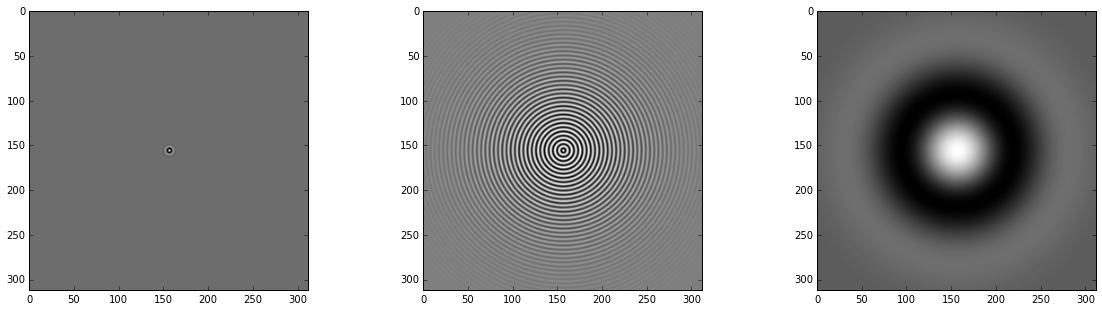

In [114]:
plt.figure(figsize=(20,5))

smallest_fastest = complex_ripple_filter(freq_df['cyc/image'].max(),(0,0),size_df['pix'].min(),pixels_per_stimulus)
plt.subplot(1,3,1)
plt.imshow(np.real(smallest_fastest),cmap=cm.gray)

biggest_fastest = complex_ripple_filter(freq_df['cyc/image'].max(),(0,0),size_df['pix'].max(),pixels_per_stimulus)
plt.subplot(1,3,2)
plt.imshow(np.real(biggest_fastest),cmap=cm.gray)


biggest_slowest = complex_ripple_filter(freq_df['cyc/image'].min(),(0,0),size_df['pix'].max(),pixels_per_stimulus)
plt.subplot(1,3,3)
plt.imshow(np.real(biggest_slowest),cmap=cm.gray)



###Fit the ripple model
Loop over all prf sizes, frequencies, and positions. At each iteration fit an independent model for each voxel. Evaluate the score against a held-out selection set. Keep track of the best model for each voxel.

In [116]:
40*25/60.

16.666666666666668

In [29]:
##some parameters of the model
hrf_length = 15 ##20 s should do it.
alpha = 1 ## I dunno. For rige regression

A special function we need for creating feature matrices w/o filling up memory.

In [30]:
def concat_wedge_bar_matrices(wedge_feature_matrix=None,bar_feature_matrix=None,run_ids=None):
    total_rows = data_db['nvols'].iloc[run_ids].sum(axis=0)
    total_cols = wedge_feature_matrix.shape[1]
    nVols = wedge_feature_matrix.shape[0]
    final_feature_matrix = np.zeros((total_rows,total_cols))
    count = 0
    for row in data_db.iloc[run_ids].iterrows():  ##apparently this gives you a tuple with the index first
        run_type = row[1].runType
        if run_type == 'bar':
            final_feature_matrix[count:count+nVols,:] = bar_feature_matrix
        elif run_type == 'wedge':
            final_feature_matrix[count:count+nVols,:] = wedge_feature_matrix
        else:
            raise Exception('run type should only be bar or wedge. something is wrong.')
        count += nVols
    return final_feature_matrix

A reasonbly efficient scoring function. Sklearn doesn't deal with scoring many models at once

In [31]:
def corr2_coeff(A,B):
    N = A.shape[0]
    # Colwise mean of input arrays & subtract from input arrays themeselves
    A_mA = A - A.mean(0)[None,:]
    B_mB = B - B.mean(0)[None,:]

    # Sum of squares across cols
    ssA = (A_mA**2).sum(0) 
    ssB = (B_mB**2).sum(0) 
    ss = np.sqrt(ssA)*np.sqrt(ssB)
    # Finally get corr coeff
    return np.sum(A_mA*B_mB,axis=0)/ss
#     return np.dot(A_mA,B_mB.T)/np.sqrt(np.dot(ssA[:,None],ssB[None]))

The main fitting / selection loop

In [32]:
##here are the guts of the fitting procedure, functionalized for each p'llization.
def main_proc(filters, p):        
#     print '===position: %d of %d' %(p, num_filters)
    wedge_features = np.abs(np.tensordot(wedge_imgs, filters[p,:,:],axes=2))
    bar_features = np.abs(np.tensordot(bar_imgs, filters[p,:,:],axes=2))
    downsampled_wedge_timeseries = preproc.nearest_neighbor_downsampling(wedge_features,wedge_nvols)
    downsampled_bar_timeseries = preproc.nearest_neighbor_downsampling(bar_features,bar_nvols)

    wedge_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_wedge_timeseries).T,
                                                            hrf_length=hrf_length)
    bar_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_bar_timeseries).T,
                                                            hrf_length=hrf_length)
    training_matrix = concat_wedge_bar_matrices(wedge_feature_matrix=wedge_feature_matrix,
                                                     bar_feature_matrix=bar_feature_matrix,
                                                     run_ids = training_runs)
#     print '=fitting model...'
    lin_mod = linear_model.Ridge(alpha=alpha,normalize=True).fit(training_matrix,training_vols)
#     print '=scoring model...'
    selection_matrix = concat_wedge_bar_matrices(wedge_feature_matrix=wedge_feature_matrix,
                                                     bar_feature_matrix=bar_feature_matrix,
                                                     run_ids = selection_runs)

    yhat = lin_mod.predict(selection_matrix)
    scr = corr2_coeff(selection_vols,yhat)
    return {p:(scr,lin_mod)}

In [33]:
##some functions for converting to polar coors on the fly. Should probably put these elsewhere
def ecc_func(x,y):
    return np.sqrt(x**2+y**2)

def ang_func(x,y):
    return np.angle(x+1j*y)


In [34]:
##this will also be useful sugar
def flatten_list_of_dicts(list_of_dicts):
    flat_dict = {}
    for d in list_of_dicts:
        flat_dict.update(d)
    return flat_dict

In [35]:
##some containers for the results
model_idx = 0
num_voxels = training_vols.shape[1]
best_scr = np.zeros(num_voxels)
best_coefs = np.zeros((num_voxels,hrf_length))
best_intercept = np.zeros(num_voxels)
best_model_dx = np.zeros(num_voxels)
model_specs = []

In [36]:
##loop over size / freq / position, updating the "best" model for each voxel on each iteration.
for kernel_size in size_df['pix']:
    for freq in freq_df['cyc/image']:
        ##print 'constructing filters...'
        print '=====size/freq pair %d' %(model_idx)
        
        filters = make_kernel_grid(freq,kernel_size,pixels_per_stimulus,(pos_x,pos_y))

        num_filters = len(pos_x.ravel())
        
        ##utilize multi-processing. model_info is list of dictionaries, each containing a score and a model object
        start = time()
        model_info = Parallel(n_jobs=3)(delayed(main_proc)(filters,p) for p in range(num_filters))
        print 'took %f minutes to pre-process images' %((time()-start)/60.)
        ##now do some packaging of the outputs
        model_info = flatten_list_of_dicts(model_info)
        for p in range(num_filters):
            model_specs.append({'size':kernel_size,
                                'freq':freq,
                                'pos_x': pos_x[p], 'pos_y': pos_y[p],
                                'ang': ang_func(pos_x[p],pos_y[p]),
                                'ecc': ecc_func(pos_x[p],pos_y[p])})
            better = np.where(model_info[p][0] > best_scr)[0] ##<<not sure why the zero. but gotta have it.
            best_scr[better] = model_info[p][0][better]
            best_coefs[better,:] = model_info[p][1].coef_[better,:]
            best_intercept[better] = model_info[p][1].intercept_[better]
            best_model_dx[better] = model_idx
            model_idx += 1
        model_info = []

=====size/freq pair 0
constructing 441 filters
took 42.827818 minutes to pre-process images
=====size/freq pair 441
constructing 441 filters
took 40.460581 minutes to pre-process images
=====size/freq pair 882
constructing 441 filters
took 40.484080 minutes to pre-process images
=====size/freq pair 1323
constructing 441 filters
took 40.127480 minutes to pre-process images
=====size/freq pair 1764
constructing 441 filters
took 35.782753 minutes to pre-process images
=====size/freq pair 2205
constructing 441 filters
took 35.793169 minutes to pre-process images
=====size/freq pair 2646
constructing 441 filters
took 35.835799 minutes to pre-process images
=====size/freq pair 3087
constructing 441 filters
took 35.748387 minutes to pre-process images
=====size/freq pair 3528
constructing 441 filters
took 35.883811 minutes to pre-process images
=====size/freq pair 3969
constructing 441 filters
took 35.741810 minutes to pre-process images
=====size/freq pair 4410
constructing 441 filters
took 

Now we unpack the results into an organized database that (should) make future analyses easier

In [2]:
#a container for the results. 
class population_model(object):
    def __init__(self,brain_mask,size_of_stim,model_df):
        self.vol_dims = brain_mask.shape
        self.brain_mask = brain_mask
        self.size_of_stim = size_of_stim
        self.model_df = model_df


In [38]:
##construct and populate database with voxel indices and model parameters for selected models
best_prf = pd.DataFrame(columns=['size','freq','pos_x','pos_y','ang','ecc','voxels','model'],dtype='int64')
new_model_dx = 0

for mm,mod_spec in enumerate(model_specs):
    these_vox = np.where(best_model_dx == mm)[0]
    if len(these_vox) < 1:
        pass
    else:
        best_prf.loc[new_model_dx,'voxels'] = these_vox
        model = linear_model.Ridge(alpha=alpha,normalize=True)
        model.coef_ = best_coefs[these_vox,:]
        model.intercept_ = best_intercept[these_vox]
        best_prf.loc[new_model_dx,'model'] = model
        best_prf.loc[new_model_dx, 'size'] = mod_spec['size']
        best_prf.loc[new_model_dx, 'freq']= mod_spec['freq']
        best_prf.loc[new_model_dx, 'pos_x'] = mod_spec['pos_x']
        best_prf.loc[new_model_dx, 'pos_y'] = mod_spec['pos_y']
        best_prf.loc[new_model_dx, 'ecc'] = mod_spec['ecc']
        best_prf.loc[new_model_dx, 'ang'] = mod_spec['ang']
        
        new_model_dx += 1

pop_mod = population_model(mask_image,
                           pixels_per_stimulus,
                           best_prf)
        

In [39]:
foo = np.zeros((2,4))
foo[[0,1]]

array([[ 0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.]])

In [40]:
best_prf.head()

,size,freq,pos_x,pos_y,ang,ecc,voxels,model
0,5.791833,2.210008,-36.66245,-122.2082,-1.862253,127.5891,"[8462, 45416, 83737, 86258]","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
1,5.791833,2.210008,-24.44163,-122.2082,-1.768192,124.6284,"[240, 51395, 68420, 126759, 143516, 165321]","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
2,5.791833,2.210008,-12.22082,-122.2082,-1.670465,122.8177,"[11488, 59747, 93467, 106233]","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
3,5.791833,2.210008,0,-122.2082,-1.570796,122.2082,"[12645, 59411, 71127, 155037, 160866]","Ridge(alpha=1, copy_X=True, fit_intercept=True..."
4,5.791833,2.210008,12.22082,-122.2082,-1.471128,122.8177,"[9903, 109828, 153548]","Ridge(alpha=1, copy_X=True, fit_intercept=True..."


A histogram of scores on the selection set. Note there is some overfitting here, because we purposefully selected 
the best of many possible models for each voxel. Don't expect the histogram on the validation data to look quite this good.

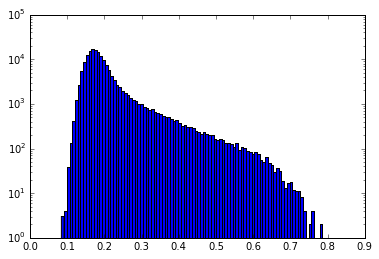

In [41]:
plt.figure
plt.hist(best_scr,100,log=True);

If we look at the temporal kernels for the best voxels (as evaluated on the selection set) we get some encouraging-looking results.

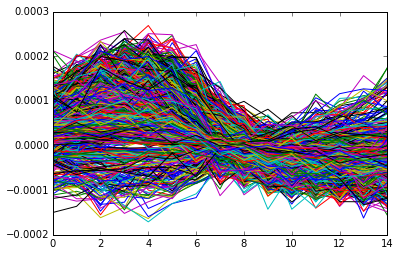

In [64]:
mxi = np.where(best_scr > 0.4)[0]
plt.figure
_ = plt.plot(best_coefs[mxi,:].T)


In [65]:
np.sum(best_scr > 0.3)

14321

Generate validation prediction scores

In [58]:
best_prf.values.nbytes/1024./1024

0.36102294921875

In [59]:
def val_proc(mod):        
#     print '===position: %d of %d' %(p, num_filters)
    idx = mod[0]
    kernel_data = mod[1]
    filters = complex_ripple_filter(kernel_data['freq'],
                                    (kernel_data['pos_x'],kernel_data['pos_y']),
                                    kernel_data['size'],
                                    pop_mod.size_of_stim)
    wedge_features = np.abs(np.tensordot(wedge_imgs, filters,axes=2))
    bar_features = np.abs(np.tensordot(bar_imgs, filters,axes=2))
    downsampled_wedge_timeseries = preproc.nearest_neighbor_downsampling(wedge_features,wedge_nvols)
    downsampled_bar_timeseries = preproc.nearest_neighbor_downsampling(bar_features,bar_nvols)

    wedge_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_wedge_timeseries).T,
                                                            hrf_length=hrf_length)
    bar_feature_matrix = preproc.construct_feature_matrix(np.atleast_2d(downsampled_bar_timeseries).T,
                                                            hrf_length=hrf_length)
    validation_matrix = concat_wedge_bar_matrices(wedge_feature_matrix=wedge_feature_matrix,
                                                     bar_feature_matrix=bar_feature_matrix,
                                                     run_ids = validation_runs)
    yhat = kernel_data['model'].predict(validation_matrix)
    scrs = corr2_coeff(validation_vols[:,kernel_data['voxels']],yhat)
    return idx,scrs,np.mean(yhat,axis=1)

In [60]:
start = time()
val_scores = Parallel(n_jobs=3)(delayed(val_proc)(mod) for mod in pop_mod.model_df.iterrows())
print time()-start

6998.54227996


In [135]:
##add val scores, predictions to the model df
pop_mod.val_df = pd.DataFrame(val_scores,columns=['idx','val_score','mean_yhat'])
pop_mod.val_df = pop_mod.val_df.set_index('idx')

##oops, add this too
pop_mod.hrf_length = hrf_length

In [136]:
pop_mod.val_df

,val_score,mean_yhat
idx,,
0,"[-0.00174638184357, -0.0122867178908, 0.026728...","[0.0385696559802, 0.0450756709541, 0.032252934..."
1,"[0.00433918271018, -0.00359168567346, 0.086309...","[-0.00831935369468, -0.00974388364567, -0.0539..."
2,"[-0.055358004376, 0.0029608315236, 0.017407873...","[-0.0645075157804, 0.00361083023072, -0.029033..."
3,"[-0.043425992218, -0.0471523142714, 0.03068597...","[-0.111580998897, -0.0778226211204, -0.0185940..."
4,"[-0.101105789854, -0.083939985985, 0.013024932...","[0.0293128518453, 0.0972537631417, 0.001751137..."
5,"[0.0103987988607, 0.0899653974549, 0.050173555...","[-0.147783229768, -0.104912995427, -0.03990018..."
6,"[0.0115069416303, 0.00756693317866]","[-0.0587745723128, -0.114549100567, -0.0615242..."
7,[0.0728975365334],"[-0.301159792997, 0.006581439265, -0.110957865..."
8,"[-0.0272110816538, -0.0279260923382, -0.082138...","[-0.0434060154301, -0.0266004447458, 0.0793864..."


In [284]:
with open('/media/tnaselar/Data/scratch/pop_mod.pkl','w') as f:
    pickle.dump(pop_mod,file = f)

In [3]:
with open('/media/tnaselar/Data/scratch/pop_mod.pkl','rb') as f:
    pop_mod = pickle.load(f)

###Model validation: correlation coeffs

In [4]:
vs = []
vx = []
for row in pop_mod.val_df['val_score']:
    vs.extend(row)

for row in pop_mod.model_df['voxels']:
    vx.extend(row)


In [11]:
np.sum(np.array(vs)>0.2)

13991

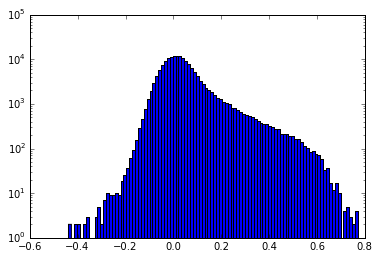

In [7]:
plt.figure
_ = plt.hist(vs,100,log=True)

In [8]:
np.sum(np.array(vs) > 0.2)

13991

###Model validation: brain visualization

We expect the map of scores (on the selection set) to look reasonable. It does. Check out the saved volumes in fslview.

In [ ]:
mean_vol = preproc.load_runs(data_db,validation_runs,detrend=False,z_score=False)
mean_vol = apply_mask(mean_vol,mask_image.ravel()).mean(axis=0)

brain_view = np.zeros(mask_image.shape).ravel()
brain_view[mask_image.ravel()] = mean_vol
brain_view = brain_view.reshape(mask_image.shape)

In [239]:
mask_dx = np.where(mask_image.ravel())[0]

In [240]:
mask_dx

array([ 119963,  120029,  120095, ..., 1472501, 1472567, 1472633])

In [244]:
score_view = np.zeros(mask_image.shape).ravel()
score_view[mask_dx[vx]]=vs
score_view = score_view.reshape(mask_image.shape)

In [246]:
nib.save(nib.Nifti1Image(brain_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/brain_view.nii')

nib.save(nib.Nifti1Image(score_view,affine=np.eye(4)),'/media/tnaselar/Data/scratch/score_view.nii')

###Model validation: temporal kernels

In [53]:
max_sign.min()

-1.0

In [49]:

n_vox = np.sum(pop_mod.brain_mask.ravel())
coeffs = np.empty((0,pop_mod.hrf_length))
for cc in pop_mod.model_df['model']:
    coeffs = np.concatenate((coeffs,cc.coef_),axis=0)

##flip sign for negative-going?    
max_sign = np.sign(np.max(coeffs,axis=1)-np.abs(np.min(coeffs,axis=1)))
coeffs = np.atleast_2d(max_sign).T*coeffs


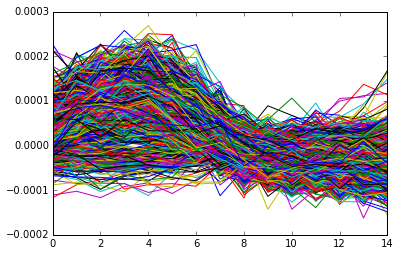

In [51]:
mxi = np.where(np.array(vs) > 0.35)[0]
plt.figure
_ = plt.plot(coeffs[mxi,:].T)

###Model validation: ecc vs. size and freq

In [55]:
pixel_per_deg = 14.12

In [17]:
##this way gives you back a dataframe, but with the grouped and aggregated data as a new column in the df.
th = 0.
def mean_specs(x):
#     count_good = lambda y: np.sum(vs[y]>th) ##<<gotta fix this
    count_good = len
    x['mean_size'] = np.sum(x['voxels'].apply(count_good)*x['size'])/np.sum(x['voxels'].apply(count_good))/pixel_per_deg
    x['mean_freq'] = np.sum(x['voxels'].apply(count_good)*x['freq'])/np.sum(x['voxels'].apply(count_good))*(1./256)*pixel_per_deg
    return x

In [18]:
ecc_group = pop_mod.model_df.groupby(['ecc'],as_index=False).apply(mean_specs)

average size (deg): 5.950760


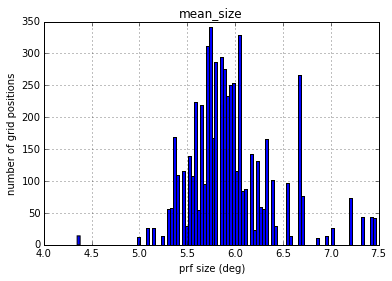

In [19]:
ecc_group.hist(column='mean_size',bins=100)
plt.xlabel('prf size (deg)')
plt.ylabel('number of grid positions')
print 'average size (deg): %f' %(ecc_group['mean_size'].mean())

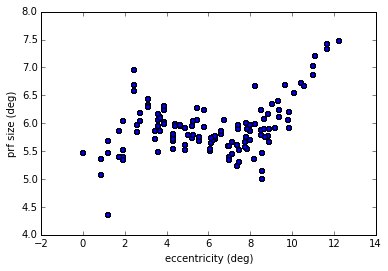

In [54]:
plt.scatter(ecc_group['ecc']/pixel_per_deg,ecc_group['mean_size'])
plt.xlabel('eccentricity (deg)')
plt.ylabel('prf size (deg)')

average cyc/deg: 1.427168


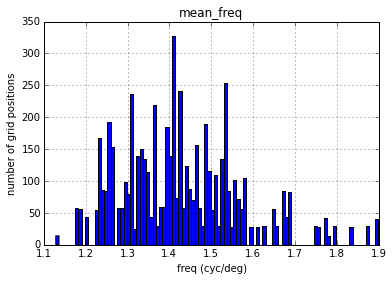

In [55]:
ecc_group.hist(column='mean_freq',bins=100)
print 'average cyc/deg: %f' %(ecc_group['mean_freq'].mean())
plt.xlabel('freq (cyc/deg)')
plt.ylabel('number of grid positions')

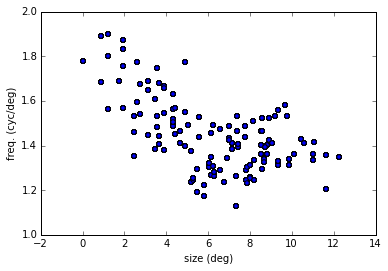

In [44]:
plt.scatter(ecc_group['ecc']/pixel_per_deg,ecc_group['mean_freq'])
plt.ylabel('freq. (cyc/deg)')
plt.xlabel('ecc (deg)')

###Model validation: projective imaging

In [54]:
pop_mod.model_df['pos_x'].min()

-122.20816666666667

In [175]:
pos_group = pop_mod.model_df.groupby(by=['pos_x','pos_y'],as_index = False)
n_times = 400
grid_shape = (21*21,n_times)
p_image = np.zeros(grid_shape)
x_min = pop_mod.model_df['pos_x'].min()
x_max = pop_mod.model_df['pos_x'].max()
y_min = pop_mod.model_df['pos_y'].min()
y_max = pop_mod.model_df['pos_y'].max()
space_unit = 1 #pixel_per_deg ##one deg.
time_unit = 1 ##one TR

##create the space-time grid for interpolating
X,Y = np.meshgrid(np.arange(x_min,x_max,space_unit),np.arange(y_min,y_max,space_unit))


##for visualizing
movie = np.zeros((n_times,len(X),len(Y)))

cnt = 0
POS_X = []
POS_Y = []
for name,grp in pos_group:
    idx = grp.index
    POS_X.append(grp.pos_x.min())
    POS_Y.append(grp.pos_y.min())
    p_image[cnt,:] = pop_mod.val_df.loc[idx,'mean_yhat'].mean()
    cnt += 1
    
for movie_frame in range(n_times):
    movie[movie_frame,:,:] = griddata((POS_X,POS_Y),p_image[:,movie_frame],(X,Y))

In [118]:
import matplotlib.animation as animation

In [178]:
dpi = 100

def ani_frame(movie):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    im = ax.imshow(rand(18,18),cmap='jet',interpolation='nearest')
    im.set_clim([-.1,.1])
    fig.set_size_inches([5,5])


    tight_layout()


    def update_img(n):
        tmp = movie[n,:,:]
        im.set_data(tmp)
        return im

    #legend(loc=0)
    ani = animation.FuncAnimation(fig,update_img,frames=400)
    writer = animation.writers['avconv'](fps=10)

    ani.save('/media/tnaselar/Data/demo.avi',writer=writer,dpi=dpi)
    return ani

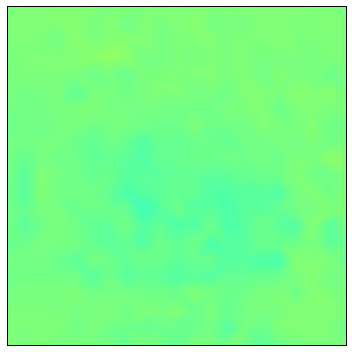

In [179]:
ani_frame(movie)

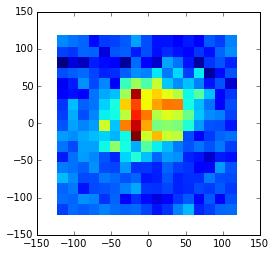

In [152]:
fig=plt.figure()
ax = fig.add_subplot(111)
plt.pcolor(X,Y,movie[175,:,:])
ax.set_aspect('equal')

In [58]:
v = np.random.rand(10,10,100)
xi,yi,ti = np.linspace(1,10,20),np.linspace(1,10,20),np.linspace(1,100,150)
griddata((x,y,t),v,(xi,yi,ti))

ValueError: shape mismatch: two or more arrays have incompatible dimensions on axis 0.

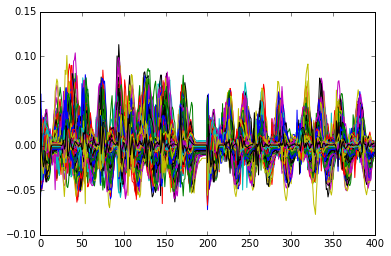

In [84]:

_=plt.plot(p_image.T)

In [52]:
np.mgrid[]

NameError: name 'p_image' is not defined

In [62]:
pop_mod.val_df.loc[10,'mean_yhat'].shape

(400,)

In [ ]:
griddata